Запустите A/A-тест

Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)

Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [21]:
import pandas as pd
import numpy as np

from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [38]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [39]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [24]:
df[df.experimentVariant==1]['purchase'].head()

0    0
2    0
3    0
4    0
5    0
Name: purchase, dtype: int64

In [25]:
df[df.experimentVariant==0]['purchase'].head()

1     0
6     0
8     0
11    0
16    0
Name: purchase, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]

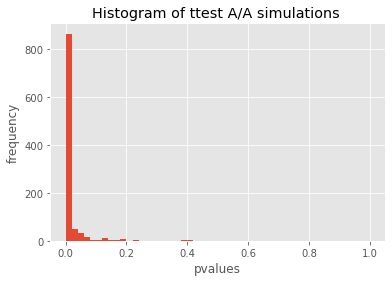

0.93

In [26]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Изучим данные в срезах по версиям ПО

In [27]:
df.groupby(['experimentVariant', 'version'], as_index=False)\
        .agg({'purchase': 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Наибольшие вопросы вызывают результаты выборок с версией ПО v2.8.0. Проверим средние данных подвыборок т-тестом

In [31]:
v280zero = df.query('experimentVariant == 0 and version == "v2.8.0"').purchase
v280one = df.query('experimentVariant == 1 and version == "v2.8.0"').purchase

In [32]:
stats.ttest_ind(v280zero, v280one)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

Тест Стьюдента показал статзначимую разницу для данной версии ПО, попробуем не включать часть этих данных в A/A тест

In [33]:
df_corr = df.query('version != "v2.8.0"')

 Проверим результаты с откорректированными данными

  0%|          | 0/1000 [00:00<?, ?it/s]

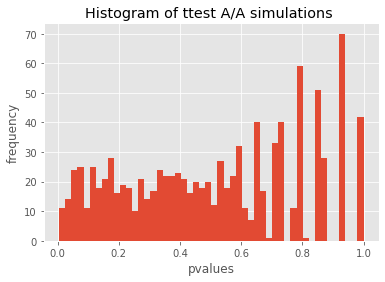

0.029

In [36]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df_corr[df_corr.experimentVariant==0]['purchase'].sample(n_s, replace = False).values
    s2 = df_corr[df_corr.experimentVariant==1]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест сошелся